In [1]:
!pip install SimpleITK matplotlib opencv-python segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.3 MB/s eta 0:00:00


In [2]:
import os
import zipfile
from google.colab import drive

# 1. 掛載 Google Drive
drive.mount('/content/drive')

# 2. 設定路徑
# 根據你的截圖，檔案路徑位於 /content/drive/MyDrive/CVPDL_final/data_2D.zip
zip_path = '/content/drive/MyDrive/CVPDL_final/data_2D.zip'
extract_path = './2D_dataset' # 解壓到 Colab 本機，讀取速度較快

# 3. 檢查檔案並解壓縮
if os.path.exists(zip_path):
    if not os.path.exists(extract_path):
        print(f"找到檔案：{zip_path}")
        print("正在解壓縮到 Colab 本機 (這可能需要幾秒鐘)...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        print("✅ 解壓縮完成！資料已準備好。")
    else:
        print("✅ 資料夾已存在，跳過解壓縮步驟。")
else:
    print(f"❌ 找不到檔案：{zip_path}")
    print("請確認 Google Drive 路徑是否完全正確，包含大小寫。")

# 4. 檢查解壓後的資料結構 (確認一下裡面是不是 Train/Test)
if os.path.exists(extract_path):
    print("資料夾內容預覽：", os.listdir(extract_path))

Mounted at /content/drive
找到檔案：/content/drive/MyDrive/CVPDL_final/data_2D.zip
正在解壓縮到 Colab 本機 (這可能需要幾秒鐘)...
✅ 解壓縮完成！資料已準備好。
資料夾內容預覽： ['metadata_2D.csv', '2D_dataset']


In [1]:
import os
import glob
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import cv2
import SimpleITK as sitk  # ✅ 替換 nibabel 為 SimpleITK
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# === 1. 設定參數與路徑 ===
DATASET_ROOT = './2D_dataset/2D_dataset'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
LR = 0.0003          # 稍微降低學習率以求穩定
EPOCHS = 30
IMG_SIZE = (256, 256)

# 對照表 (詳細 -> 粗略)
ROUGH_MAPPING = {
    0: 0, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 0,
    7: 3, 8: 4, 9: 4, 10: 4, 11: 4
}

# === 2. 智慧型資料集劃分 (Patient-wise Split) ===
def get_split_files(root_dir, val_ratio=0.2, random_seed=42):
    """
    根據病人 ID (例如 THIGH_001) 進行切分，防止 Data Leakage。
    """
    image_dir = os.path.join(root_dir, 'train', 'image')
    detailed_dir = os.path.join(root_dir, 'train', 'detailed_label')

    # 取得所有標籤檔
    label_paths = sorted(glob.glob(os.path.join(detailed_dir, '*_detailed.nii.gz')))

    # 建立 Patient ID -> File List 的字典
    patient_map = {}

    print("正在依照病人 ID 進行分組...")
    for lbl_path in label_paths:
        filename = os.path.basename(lbl_path)

        # 嘗試解析 Patient ID (根據你的檔名：0_0_THIGH_001_Fat...)
        # 使用 Regex 抓取 "THIGH_數字"
        match = re.search(r"(THIGH_\d+)", filename)
        if match:
            pid = match.group(1)
        else:
            # 如果找不到規則，就退回到用前幾個字元分組 (Fallback)
            pid = "unknown"

        # 檢查對應的 Image 是否存在
        img_name = filename.replace('_detailed.nii.gz', '.nii.gz')
        img_path = os.path.join(image_dir, img_name)

        if os.path.exists(img_path):
            if pid not in patient_map:
                patient_map[pid] = []
            patient_map[pid].append((img_path, lbl_path))

    # 取得所有病人 ID 列表
    all_patients = list(patient_map.keys())
    train_pids, val_pids = train_test_split(all_patients, test_size=val_ratio, random_state=random_seed)

    train_files = []
    for pid in train_pids:
        train_files.extend(patient_map[pid])

    val_files = []
    for pid in val_pids:
        val_files.extend(patient_map[pid])

    print(f"✅ 總病人數: {len(all_patients)}")
    print(f"   Train Patients: {len(train_pids)} -> {len(train_files)} images")
    print(f"   Val Patients:   {len(val_pids)} -> {len(val_files)} images")

    return train_files, val_files

# === 3. 優化後的 Dataset (SimpleITK + Percentile Clipping) ===
class RobustThighDataset(Dataset):
    def __init__(self, file_pairs, target_size=(256, 256), augment=False, target_orientation="LPS"):
        self.file_pairs = file_pairs
        self.target_size = target_size
        self.augment = augment # 預留擴增接口
        self.target_orientation = target_orientation # ✅ 設定目標方向 (LPS)

    def __len__(self):
        return len(self.file_pairs)

    def load_and_reorient(self, path):
        """
        修正版：自動判斷維度，如果是 2D 則跳過 DICOMOrientImageFilter
        """
        # 1. 讀取影像
        sitk_img = sitk.ReadImage(path)

        # 2. 檢查維度
        # 如果是 3D 影像，才執行方向校正
        if sitk_img.GetDimension() == 3 and sitk_img.GetSize()[2] > 1:
            try:
                orient_filter = sitk.DICOMOrientImageFilter()
                orient_filter.SetDesiredCoordinateOrientation(self.target_orientation)
                sitk_img = orient_filter.Execute(sitk_img)
            except Exception as e:
                # 如果方向轉換失敗，印出警告但不要崩潰，直接使用原圖
                print(f"Warning: Orientation failed for {os.path.basename(path)}, utilizing original image. Error: {e}")

        # 3. 轉為 Numpy Array
        # SimpleITK 順序是 (z, y, x) 或 (y, x)
        img_arr = sitk.GetArrayFromImage(sitk_img)

        # 4. 移除多餘維度 (Squeeze)
        # 例如 (1, 256, 256) -> (256, 256)
        img_arr = np.squeeze(img_arr)

        return img_arr

    def preprocess_image(self, img):
        """
        優化版預處理：
        1. Percentile Clipping: 去除前 0.5% 極端亮點
        2. Min-Max Scaling
        """
        img = img.astype(np.float32)

        # Clipping: 避免極端值影響整體
        lower = np.percentile(img, 0.5)
        upper = np.percentile(img, 99.5)

        img = np.clip(img, lower, upper)

        # Normalize to 0-1
        if upper - lower > 0:
            img = (img - lower) / (upper - lower)
        else:
            img = img - lower # 避免除以零

        return img

    def resize_data(self, data, is_mask=False):
        method = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
        return cv2.resize(data, self.target_size, interpolation=method)

    def __getitem__(self, idx):
        img_path, lbl_path = self.file_pairs[idx]

        try:
            # ✅ 使用 SimpleITK 讀取並統一方向
            image_data = self.load_and_reorient(img_path)
            det_mask = self.load_and_reorient(lbl_path)

            # 預處理
            image_data = self.preprocess_image(image_data)
            image_data = self.resize_data(image_data, is_mask=False)

            det_mask = self.resize_data(det_mask, is_mask=True)

            # 產生 Rough Label
            rough_mask = np.zeros_like(det_mask)
            for d, r in ROUGH_MAPPING.items():
                rough_mask[det_mask == d] = r

            # 轉 Tensor
            # Image: (C, H, W) -> (3, 256, 256) for ResNet backbone
            image_tensor = torch.from_numpy(np.stack([image_data]*3, axis=0)).float()
            det_tensor = torch.from_numpy(det_mask).long()
            rough_tensor = torch.from_numpy(rough_mask).long()

            return image_tensor, det_tensor, rough_tensor

        except Exception as e:
            print(f"Error loading {os.path.basename(img_path)}: {e}")
            return torch.zeros(3, *self.target_size), torch.zeros(self.target_size).long(), torch.zeros(self.target_size).long()

# === 4. 模型定義 (保持不變) ===
class MultiHeadUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )
        self.encoder = self.backbone.encoder
        self.decoder = self.backbone.decoder

        # Heads
        self.head_rough = nn.Conv2d(16, 5, kernel_size=1)   # 5類
        self.head_detailed = nn.Conv2d(16, 12, kernel_size=1) # 12類

    def forward(self, x):
        features = self.encoder(x)
        # Fix decoder args issue
        try:
            decoder_output = self.decoder(*features)
        except TypeError:
            decoder_output = self.decoder(features)

        out_rough = self.head_rough(decoder_output)
        out_detailed = self.head_detailed(decoder_output)
        return out_rough, out_detailed

# === 5. 訓練函式 (加入 Dice + Focal Loss) ===
def run_optimized_training():
    # 1. 準備檔案列表 (Patient-wise Split)
    train_files, val_files = get_split_files(DATASET_ROOT)

    # 2. 建立 Dataset & DataLoader
    # ✅ SimpleITK 版本
    train_ds = RobustThighDataset(train_files, target_size=IMG_SIZE, augment=True)
    val_ds = RobustThighDataset(val_files, target_size=IMG_SIZE, augment=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # 3. 初始化模型
    model = MultiHeadUNet().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

    # 4. 定義混合 Loss (Dice + Focal)
    # 這能有效解決 0.3% vs 91% 的不平衡問題
    dice_loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    focal_loss_fn = smp.losses.FocalLoss(mode='multiclass')

    # 記錄
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    print(f"\n🚀 Start Optimized Training on {DEVICE}...")

    for epoch in range(EPOCHS):
        # --- Train ---
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")

        for imgs, det_masks, rough_masks in loop:
            imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)

            optimizer.zero_grad()
            out_rough, out_detailed = model(imgs)

            # Loss 計算：Detailed 權重稍大一點，因為它比較難
            # Loss = Dice (形狀) + Focal (難易度)
            loss_det = dice_loss_fn(out_detailed, det_masks) + focal_loss_fn(out_detailed, det_masks)
            loss_rough = dice_loss_fn(out_rough, rough_masks) + focal_loss_fn(out_rough, rough_masks)

            loss = 0.6 * loss_det + 0.4 * loss_rough

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- Val ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, det_masks, rough_masks in val_loader:
                imgs, det_masks, rough_masks = imgs.to(DEVICE), det_masks.to(DEVICE), rough_masks.to(DEVICE)

                out_rough, out_detailed = model(imgs)

                loss_det = dice_loss_fn(out_detailed, det_masks) + focal_loss_fn(out_detailed, det_masks)
                loss_rough = dice_loss_fn(out_rough, rough_masks) + focal_loss_fn(out_rough, rough_masks)
                loss = 0.6 * loss_det + 0.4 * loss_rough

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"   📊 Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # 儲存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_thigh_model_opt.pth')
            print("   💾 Best model saved!")

    print("✅ Training Complete.")
    return model

if __name__ == '__main__':
    # 執行訓練
    trained_model = run_optimized_training()

正在依照病人 ID 進行分組...
✅ 總病人數: 83
   Train Patients: 66 -> 4232 images
   Val Patients:   17 -> 1168 images


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



🚀 Start Optimized Training on cuda...


Epoch 1/30 [Train]: 100%|██████████| 265/265 [01:25<00:00,  3.10it/s, loss=1.48]


   📊 Train Loss: 1.9534 | Val Loss: 1.4697
   💾 Best model saved!


Epoch 2/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.39it/s, loss=1.04]


   📊 Train Loss: 1.2182 | Val Loss: 1.0458
   💾 Best model saved!


Epoch 3/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.37it/s, loss=0.839]


   📊 Train Loss: 0.9327 | Val Loss: 0.8529
   💾 Best model saved!


Epoch 4/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.38it/s, loss=0.65]


   📊 Train Loss: 0.7439 | Val Loss: 0.6911
   💾 Best model saved!


Epoch 5/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.40it/s, loss=0.48]


   📊 Train Loss: 0.5576 | Val Loss: 0.5362
   💾 Best model saved!


Epoch 6/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.41it/s, loss=0.335]


   📊 Train Loss: 0.3868 | Val Loss: 0.3945
   💾 Best model saved!


Epoch 7/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.41it/s, loss=0.237]


   📊 Train Loss: 0.2514 | Val Loss: 0.3088
   💾 Best model saved!


Epoch 8/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.37it/s, loss=0.178]


   📊 Train Loss: 0.1816 | Val Loss: 0.2728
   💾 Best model saved!


Epoch 9/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.36it/s, loss=0.164]


   📊 Train Loss: 0.1470 | Val Loss: 0.2689
   💾 Best model saved!


Epoch 10/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.36it/s, loss=0.109]


   📊 Train Loss: 0.1285 | Val Loss: 0.2582
   💾 Best model saved!


Epoch 11/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.37it/s, loss=0.118]


   📊 Train Loss: 0.1151 | Val Loss: 0.2544
   💾 Best model saved!


Epoch 12/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.43it/s, loss=0.129]


   📊 Train Loss: 0.1045 | Val Loss: 0.2541
   💾 Best model saved!


Epoch 13/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.42it/s, loss=0.1]


   📊 Train Loss: 0.0961 | Val Loss: 0.2552


Epoch 14/30 [Train]: 100%|██████████| 265/265 [01:19<00:00,  3.34it/s, loss=0.0969]


   📊 Train Loss: 0.0910 | Val Loss: 0.2532
   💾 Best model saved!


Epoch 15/30 [Train]: 100%|██████████| 265/265 [01:19<00:00,  3.33it/s, loss=0.0933]


   📊 Train Loss: 0.0865 | Val Loss: 0.2560


Epoch 16/30 [Train]: 100%|██████████| 265/265 [01:19<00:00,  3.34it/s, loss=0.0788]


   📊 Train Loss: 0.0812 | Val Loss: 0.2563


Epoch 17/30 [Train]: 100%|██████████| 265/265 [01:19<00:00,  3.35it/s, loss=0.0755]


   📊 Train Loss: 0.0771 | Val Loss: 0.2586


Epoch 18/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.36it/s, loss=0.0883]


   📊 Train Loss: 0.0742 | Val Loss: 0.2587


Epoch 19/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.41it/s, loss=0.0642]


   📊 Train Loss: 0.0710 | Val Loss: 0.2647


Epoch 20/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.40it/s, loss=0.0661]


   📊 Train Loss: 0.0687 | Val Loss: 0.2581


Epoch 21/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.40it/s, loss=0.067]


   📊 Train Loss: 0.0670 | Val Loss: 0.2632


Epoch 22/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.36it/s, loss=0.0617]


   📊 Train Loss: 0.0640 | Val Loss: 0.2612


Epoch 23/30 [Train]: 100%|██████████| 265/265 [01:19<00:00,  3.35it/s, loss=0.0668]


   📊 Train Loss: 0.0622 | Val Loss: 0.2677


Epoch 24/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.38it/s, loss=0.053]


   📊 Train Loss: 0.0611 | Val Loss: 0.2692


Epoch 25/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.41it/s, loss=0.0725]


   📊 Train Loss: 0.0592 | Val Loss: 0.2672


Epoch 26/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.42it/s, loss=0.0575]


   📊 Train Loss: 0.0582 | Val Loss: 0.2694


Epoch 27/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.39it/s, loss=0.052]


   📊 Train Loss: 0.0562 | Val Loss: 0.2716


Epoch 28/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.38it/s, loss=0.0528]


   📊 Train Loss: 0.0551 | Val Loss: 0.2746


Epoch 29/30 [Train]: 100%|██████████| 265/265 [01:18<00:00,  3.39it/s, loss=0.0482]


   📊 Train Loss: 0.0540 | Val Loss: 0.2751


Epoch 30/30 [Train]: 100%|██████████| 265/265 [01:17<00:00,  3.42it/s, loss=0.0613]


   📊 Train Loss: 0.0540 | Val Loss: 0.2796
✅ Training Complete.


✅ 成功載入模型權重：best_thigh_model_opt.pth
📂 找到 1055 張測試圖片。


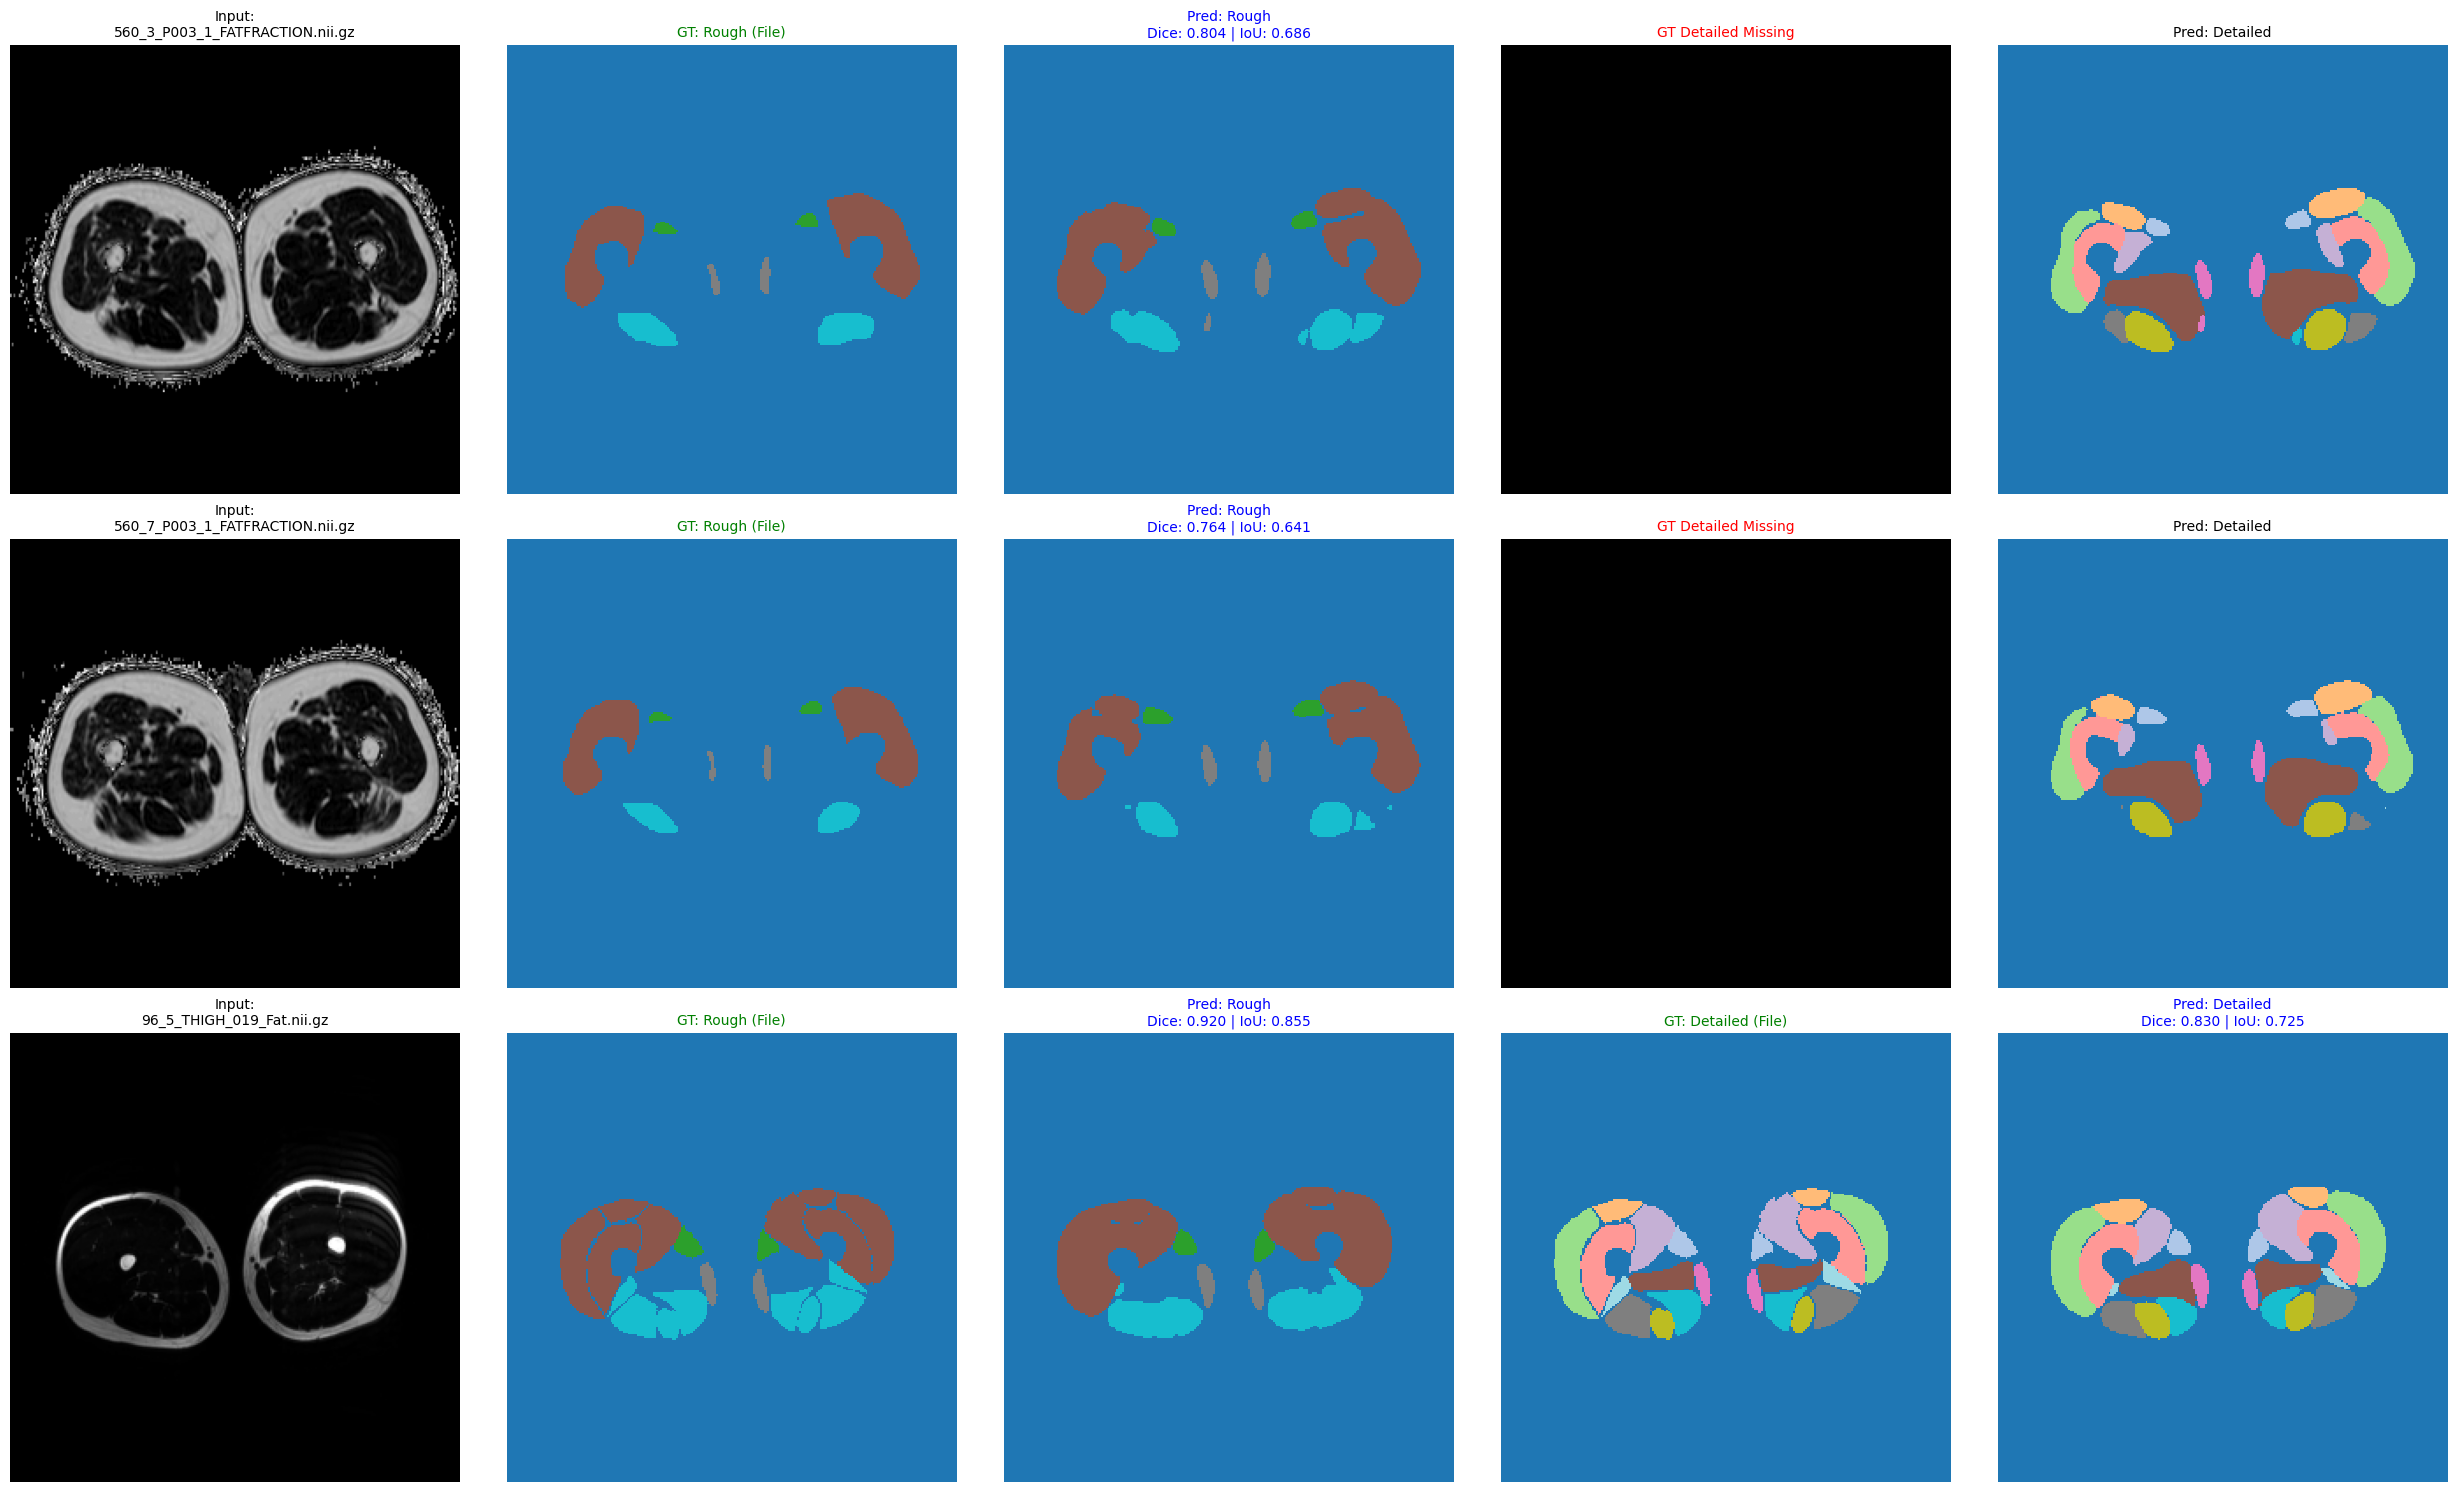

In [12]:
import os
import glob
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import SimpleITK as sitk

# ==========================================
# 1. 定義評估指標計算函數
# ==========================================
def calculate_img_metrics(pred_mask, gt_mask, num_classes):
    """
    計算單張影像的 Mean Dice 與 Mean IoU
    """
    dice_scores = []
    iou_scores = []

    for c in range(num_classes):
        p = (pred_mask == c).astype(np.float32)
        g = (gt_mask == c).astype(np.float32)

        intersection = np.sum(p * g)
        union_dice = np.sum(p) + np.sum(g)
        union_iou = np.sum(p) + np.sum(g) - intersection

        # Dice
        if union_dice == 0:
            dice = 1.0
        else:
            dice = (2.0 * intersection) / (union_dice + 1e-8)

        # IoU
        if union_iou == 0:
            iou = 1.0
        else:
            iou = intersection / (union_iou + 1e-8)

        dice_scores.append(dice)
        iou_scores.append(iou)

    return np.mean(dice_scores), np.mean(iou_scores)

# ==========================================
# 2. 定義預處理函數
# ==========================================
def preprocess_for_inference(img_path, target_size=(256, 256)):
    sitk_img = sitk.ReadImage(img_path)
    img_arr = sitk.GetArrayFromImage(sitk_img)
    img_arr = np.squeeze(img_arr)

    img_arr = img_arr.astype(np.float32)
    lower = np.percentile(img_arr, 0.5)
    upper = np.percentile(img_arr, 99.5)
    img_arr = np.clip(img_arr, lower, upper)

    if upper - lower > 0:
        img_arr = (img_arr - lower) / (upper - lower)

    display_img = cv2.resize(img_arr, target_size, interpolation=cv2.INTER_LINEAR)

    img_tensor = torch.from_numpy(np.stack([display_img]*3, axis=0)).float()
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor, display_img

# ==========================================
# 3. 通用的讀取 Label 函數 (支援 Rough 與 Detailed)
# ==========================================
def load_specific_label(img_path, label_type='detailed', target_size=(256, 256)):
    """
    根據 label_type ('rough' 或 'detailed') 讀取對應資料夾下的標籤
    """
    try:
        basename = os.path.basename(img_path)
        name_no_ext = basename.replace('.nii.gz', '')

        # 取得上一層目錄 (test 資料夾)
        base_dir = os.path.dirname(os.path.dirname(img_path))

        # 設定目標資料夾與檔名後綴
        if label_type == 'rough':
            target_folder = 'rough_label'
            suffix = '_rough.nii.gz'
        else:
            target_folder = 'detailed_label'
            suffix = '_detailed.nii.gz'

        label_dir = os.path.join(base_dir, target_folder)

        # 組合路徑：例如 138_0_THIGH..._rough.nii.gz
        label_name = f"{name_no_ext}{suffix}"
        label_path = os.path.join(label_dir, label_name)

        # 讀取檔案
        if os.path.exists(label_path):
            sitk_lbl = sitk.ReadImage(label_path)
            lbl_arr = sitk.GetArrayFromImage(sitk_lbl)
            lbl_arr = np.squeeze(lbl_arr)
            # 使用 Nearest Neighbor 縮放以保持類別整數
            gt_mask = cv2.resize(lbl_arr, target_size, interpolation=cv2.INTER_NEAREST)
            return gt_mask, True
        else:
            # 防呆：如果找不到帶後綴的檔案，試試看原檔名 (有時候命名不統一)
            label_path_alt = os.path.join(label_dir, basename)
            if os.path.exists(label_path_alt):
                sitk_lbl = sitk.ReadImage(label_path_alt)
                lbl_arr = sitk.GetArrayFromImage(sitk_lbl)
                lbl_arr = np.squeeze(lbl_arr)
                gt_mask = cv2.resize(lbl_arr, target_size, interpolation=cv2.INTER_NEAREST)
                return gt_mask, True

    except Exception as e:
        print(f"Error loading {label_type} GT: {e}")

    return np.zeros(target_size), False

# ==========================================
# 4. 載入模型權重
# ==========================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = 'best_thigh_model_opt.pth'

try:
    model = MultiHeadUNet().to(DEVICE)
except NameError:
    print("❌ 錯誤：找不到 MultiHeadUNet 類別，請先執行包含模型定義的程式碼區塊。")

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print(f"✅ 成功載入模型權重：{model_path}")
else:
    print(f"❌ 找不到權重檔 '{model_path}'")

model.eval()

# ==========================================
# 5. 搜尋 Test Set 圖片
# ==========================================
test_image_root = './2D_dataset/2D_dataset/test/image'
test_images = sorted(glob.glob(os.path.join(test_image_root, '*.nii.gz')))
print(f"📂 找到 {len(test_images)} 張測試圖片。")

# ==========================================
# 6. 執行預測並視覺化 (5 Columns)
# ==========================================
if len(test_images) > 0:
    samples_to_show = random.sample(test_images, min(3, len(test_images)))

    plt.figure(figsize=(25, 5 * len(samples_to_show)))

    with torch.no_grad():
        for i, img_path in enumerate(samples_to_show):
            filename = os.path.basename(img_path)

            # A. 輸入處理
            input_tensor, display_img = preprocess_for_inference(img_path)
            input_tensor = input_tensor.to(DEVICE)

            # B. 讀取 Ground Truth (分別讀取 Rough 和 Detailed)
            gt_rough, rough_exists = load_specific_label(img_path, label_type='rough')
            gt_detailed, detailed_exists = load_specific_label(img_path, label_type='detailed')

            # C. 推論
            out_rough, out_detailed = model(input_tensor)
            pred_rough = torch.argmax(out_rough, dim=1).cpu().numpy()[0]
            pred_detailed = torch.argmax(out_detailed, dim=1).cpu().numpy()[0]

            # D. 計算分數
            title_rough = ""
            title_detailed = ""

            # 計算 Rough 分數
            if rough_exists:
                d_r, i_r = calculate_img_metrics(pred_rough, gt_rough, num_classes=5)
                title_rough = f"\nDice: {d_r:.3f} | IoU: {i_r:.3f}"

            # 計算 Detailed 分數
            if detailed_exists:
                d_d, i_d = calculate_img_metrics(pred_detailed, gt_detailed, num_classes=12)
                title_detailed = f"\nDice: {d_d:.3f} | IoU: {i_d:.3f}"

            # --- 繪圖 (5 Columns) ---
            # 1. Input
            plt.subplot(len(samples_to_show), 5, i*5 + 1)
            plt.imshow(display_img, cmap='gray')
            plt.title(f"Input:\n{filename}", fontsize=10)
            plt.axis('off')

            # 2. GT Rough (從檔案讀取)
            plt.subplot(len(samples_to_show), 5, i*5 + 2)
            if rough_exists:
                plt.imshow(gt_rough, cmap='tab10', interpolation='nearest', vmin=0, vmax=4)
                plt.title("GT: Rough (File)", fontsize=10, color='green')
            else:
                plt.imshow(np.zeros_like(display_img), cmap='gray')
                plt.title("GT Rough Missing", fontsize=10, color='red')
            plt.axis('off')

            # 3. Pred Rough
            plt.subplot(len(samples_to_show), 5, i*5 + 3)
            plt.imshow(pred_rough, cmap='tab10', interpolation='nearest', vmin=0, vmax=4)
            plt.title(f"Pred: Rough{title_rough}", fontsize=10, color='blue' if rough_exists else 'black')
            plt.axis('off')

            # 4. GT Detailed (從檔案讀取)
            plt.subplot(len(samples_to_show), 5, i*5 + 4)
            if detailed_exists:
                plt.imshow(gt_detailed, cmap='tab20', interpolation='nearest', vmin=0, vmax=11)
                plt.title("GT: Detailed (File)", fontsize=10, color='green')
            else:
                plt.imshow(np.zeros_like(display_img), cmap='gray')
                plt.title("GT Detailed Missing", fontsize=10, color='red')
            plt.axis('off')

            # 5. Pred Detailed
            plt.subplot(len(samples_to_show), 5, i*5 + 5)
            plt.imshow(pred_detailed, cmap='tab20', interpolation='nearest', vmin=0, vmax=11)
            plt.title(f"Pred: Detailed{title_detailed}", fontsize=10, color='blue' if detailed_exists else 'black')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 沒有找到測試圖片。")

In [6]:
import os
import datetime
from google.colab import drive
import shutil
# ==========================================
# 1. 確保 Google Drive 已掛載
# ==========================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("✅ Google Drive 掛載成功！")
else:
    print("✅ Google Drive 已經掛載。")

# ==========================================
# 2. 設定備份來源與目的地
# ==========================================
# (A) 您想備份的檔案 (例如訓練好的模型)
source_files = [
    'best_thigh_model_opt.pth',  # 這是您剛剛訓練的最佳模型
    # 'metadata_2D.csv',         # 如果有其他檔案想備份，可以加在這裡
]

# (B) Google Drive 上的目的地資料夾
# 建議存回原本的 CVPDL_final 資料夾，並加上日期以免覆蓋舊檔
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
dest_folder = f'/content/drive/MyDrive/CVPDL_final/backup_{timestamp}'

# ==========================================
# 3. 執行備份
# ==========================================
# 建立備份資料夾
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
    print(f"📂 已在 Drive 建立備份資料夾：{dest_folder}")

print("🚀 開始備份...")

for file_name in source_files:
    if os.path.exists(file_name):
        # 複製檔案
        shutil.copy(file_name, dest_folder)
        print(f"   ✅ 已備份：{file_name}")
    else:
        print(f"   ⚠️ 找不到檔案：{file_name} (可能尚未訓練完成或檔名錯誤)")

print(f"\n🎉 備份完成！請到 Google Drive 確認資料夾：\n   {dest_folder}")

✅ Google Drive 已經掛載。
📂 已在 Drive 建立備份資料夾：/content/drive/MyDrive/CVPDL_final/backup_20251126_1614
🚀 開始備份...
   ✅ 已備份：best_thigh_model_opt.pth

🎉 備份完成！請到 Google Drive 確認資料夾：
   /content/drive/MyDrive/CVPDL_final/backup_20251126_1614
